# Incitations RRQ

Dans ce notebook, on calcule le gain marginal a reporter le début de la rente retraite du RRQ. Nous avons construit un calculateur des rentes (cpp), un outils pour obtenir des taux de survie historique et prospectifs. Quelques notes sur chacun des éléments:

RRQ:
- prise en compte de la rente retraite seulement et des pénalités actuarielles pour prestation anticipé et retardé. 

Survie:
- taux historique venant de la Banque de donnée sur la longévité canadienne et taux prospectif par province de Statistiques Canada

In [1]:
from calculators import cpp
from calculators import life
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

On va chercher les taux de survie (nous supposerons un homme au Québec) :

In [2]:
l = life.table()

On va chercher les règles du RRQ

In [3]:
qpp = cpp.rules(qpp=True)

Le module cpp contient un routine permettant de calculer un cas juqu'au début des prestations. Nous allons rouler ce cas jusqu'à l'âge de 60 ans (il aura fait au moins des contributions jusqu'à l'âge de 59 ans). Nous le ferons dans un contexte simple au départ. L'individu est né en 1958 et à 59 ans en 2017, 60 ans en 2018. 

In [4]:
byr = 1958
case = cpp.account(byr,rules=qpp)

Allons chercher les probabilités de survie étant donné qu'il a 60 ans:

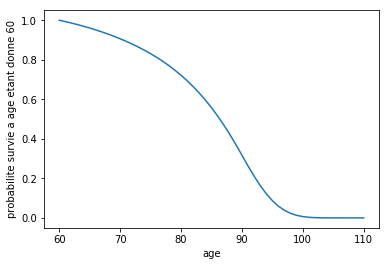

In [5]:
sx = [l.sx(byr,60,a) for a in range(60,111)]
ages = [i for i in range(60,111)]
plt.figure()
plt.plot(ages,sx)
plt.xlabel('age')
plt.ylabel('probabilite survie a age etant donne 60')
plt.show()
sx = dict(zip(ages,sx))

Son esperance de vie residuelle (apres 60 ans) est 

In [6]:
print('e60 = ', l.ex(byr,60))

e60 =  24.928808875806567


On va maintenant rouler 10 cas pour chacun des ages possibles. A chaque fois on va suppose qu'il ne continue pas a travailler apres 60 ans et qu'il a toujours gagne le MGA:


In [7]:
benefits = []
claimages = [i for i in range(60,70)]
for a in range(60,70):
    case.RunCase(claimage=a,retage=60,ratio=1.0)
    benefits.append(case.benefit)
    case.ResetCase() 
brrq = dict(zip(claimages,benefits))
print(brrq)


{60: 745.3333333333333, 61: 810.9873657407405, 62: 879.381885855856, 63: 951.902619410965, 64: 1029.8543663442222, 65: 1114.473326940932, 66: 1213.982203898624, 67: 1315.217781886009, 68: 1418.3297666051035, 69: 1523.46454191272}


In [8]:
sx[60]

1.0

In [9]:
npv = []
rate = 0.03
for a in claimages:
    npv.append(np.sum([np.exp(-rate*(aa-60))*brrq[a]*12*sx[aa] for aa in range(a,111)]))
npv = dict(zip(claimages,npv))

In [10]:
[print(a,np.round(npv[a],0)) for a in claimages]

60 153584.0
61 157381.0
62 160484.0
63 163114.0
64 165427.0
65 167520.0
66 170433.0
67 172109.0
68 172621.0
69 172042.0


[None, None, None, None, None, None, None, None, None, None]

Le gain a reporter en dollars (en valeur d'option) est donne par:

In [11]:
acc = []
for a in range(60,69):
    maxnpv = np.max([npv[x] for x in range(a+1,70)])
    acc.append(maxnpv - npv[a])
acc = dict(zip(claimages[:-1],acc))
[print(a,np.round(acc[a],0)) for a in claimages[:-1]]


60 19037.0
61 15240.0
62 12138.0
63 9507.0
64 7194.0
65 5102.0
66 2188.0
67 513.0
68 -579.0


[None, None, None, None, None, None, None, None, None]

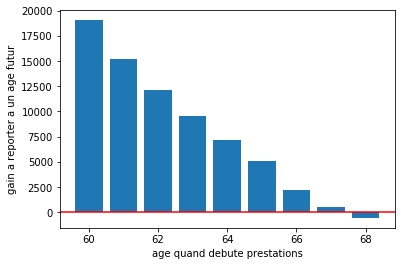

In [12]:
plt.figure()
plt.bar(claimages[:-1],[acc[a] for a in claimages[:-1]])
plt.xlabel('age quand debute prestations')
plt.ylabel('gain a reporter a un age futur')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()